In [ ]:
def ETMTM(P,D,TB,NT,dt,tag='data',nalphas=20, Poverlap=0.9, win_len=100):
    """
    Extended time multi-taper deconvolution.
    Originally written for Malab by Ved Lekic.
    Translated to Python by Nick Mancinelli.

    For deconvolving S-to-P receiver functions.

    Inputs:
            P
            D
            TB
            NT
            t0
            t1
            dt
            tag

    Returns: RF_Time

    Findings: when P arrival is not in the center of the window, the
    amplitudes are not unity at the beginning and decreasing from there on.
    Instead they peak at the time shift which corresponds to the middle index
    in the P time window.

    As your TB
    increases, the frequency smearing gets worse, which means that the RFs
    degrate at shorter and shorter lag times. Therefore, as you increase TB,
    you should also increase Poverlap.

    TB = 4; NT = 7; %choise of TB = 4, NT = 3 is supposed to be optimal
    t0 = -5; t1 = max(time);
        function [RF_Time] = MTMDecon_VedOptimized(P,D,TB,NT,t0,t1,Faza)
    Ved wrote MTM for MATLAB, which has the added advantage of
    finding the optimal damping parameter.
    TB  = time bandwidth product (usually between 2 and 4)
    NT  = number of tapers to use, has to be <= 2*TB-1
    """

    # Flip time axis in case of Sp
    from numpy import fliplr, round, zeros, concatenate, arange, where
    from numpy import logspace, var, std, median
    from numpy.fft import fft, ifft, fftshift
    from numpy import shape
    from numpy import hanning
    from scipy.interpolate import interp1d
    from nitime.algorithms.spectral import dpss_windows
    from numpy import array, conj, real
    from scipy.signal import convolve
    from numpy import nanmean, nansum
    from numpy import std, argmin, flipud


    D,P = D[::-1], P[::-1]

    # Length of moving time window in seconds
    Nwin = int(round(win_len/dt))
    
    # Fraction of overlap overlap between moving time windows. As your TB
    # increases, the frequency smearing gets worse, which means that the RFs
    # degrate at shorter and shorter lag times. Therefore, as you increase TB,
    # you should also increase Poverlap.
    nso=(1-Poverlap)*Nwin
    nso=int(round(nso))

    npad=zeros(nso)
    D=concatenate((npad,D,npad))
    P=concatenate((P,npad,npad))

    #MATLAB time = 0:dt:dt*(length(P)-1);
    time = arange(0,len(P))*dt
    t1 = max(time)
    t0 = -5

    # Create moving time windows and daughter/parent snippets
    #  MLAB starts = 1:round((1-Poverlap)*Nwin):length(P)-Nwin+1
    tmp=int(round((1-Poverlap)*Nwin))
    starts = range(1,len(P)-Nwin+1,tmp)
    nd=0

    #init tmp_times
    tmp_times=zeros(len(starts)*Nwin).reshape(len(starts),Nwin)
    Dwin=zeros(Nwin*len(starts)).reshape(len(starts),Nwin)

    for j in range(len(starts)):
        tmp_times[j,:(Nwin-1)] = time[starts[j]:starts[j]+Nwin-1]
        if j==0: # ASSUME THAT PARENT PHASE IS CENTERED IN FIRST WINDOW!
            #Pwin = interp1(double(time),double(P),double(tmp_times(j,:)),'linear',0)';
            Pwin = interp1d(time,P)(tmp_times[j,:])


        #print(j, tmp_times[j,:(Nwin-1)][0], tmp_times[j,:(Nwin-1)][-1])
        #print(len(time), len(D), len(tmp_times[j,:]))
        #Dwin(1:Nwin,j) = interp1(double(time),double(D),double(tmp_times(j,:)),'linear',0);
        Dwin[j,:Nwin] = interp1d(time,D)(tmp_times[j,:])

        ltp=win_len/5 # taper before deconvolving (important for synthetics)
        #NICK FIND A TAPER SUBROUTINE TO DEAL WITH NEXT 3 LINES
        #Dwin[1:Nwin,j]=taper(Dwin(1:Nwin,j)',tmp_times(j,1:Nwin),ltp,dt,tmp_times(j,1+round((ltp+dt)/dt)),tmp_times(j,Nwin-round((ltp+dt)/dt)));
        #

        #TheTaper=hanning(ltp*3/dt-2)
        #ind1=round((ltp+dt)/dt)
        #ind2=Nwin-round((ltp+dt)/dt)
        #Dwin[j,ind1:ind2]=Dwin[j,ind1:ind2] * TheTaper

        #from matplotlib import pylab as plt
        #plt.plot(Dwin[ind1:ind2,j])
        #plt.plot(TheTaper)
        #plt.show()

        #nd1=length(find(Dwin(:,j)>1e-2))

        #print '*** Warning no taper!!!'
        #Dwin[:Nwin,j]=taper(Dwin[:Nwin,j],tmp_times[j,:Nwin],ltp,dt,tmp_times[j,1+round((ltp+dt)/dt)],tmp_times[j,Nwin-round((ltp+dt)/dt)])

        nd1=len(where(Dwin[:,j]>1e-2))
        if nd1>nd:
            nd=nd1

    # Search range for optimal damping parameter alpha
    if tag=='data':
        tmpind=len(D)
        alphas = logspace(-2,2,nalphas)*var(D[int(round(tmpind/4)):3*int(round(tmpind/4))])*len(P)
    elif tag =='synth':
        alphas = logspace(-2,2,nalphas)*var(D)*len(P)

    # Figure out average times for each moving window
    t0_times = median(tmp_times,1);

    # Construct Slepians
    #[E,~] = dpss(length(Pwin),TB);

    E,dummy = dpss_windows(len(Pwin),TB,NT)
    E=E


    # Length of waveforms;
    nh = len(Pwin)

    #
    tmpint=shape(tmp_times)[0]

    tmpint2=len(arange(t0,t1+dt,dt))

    RF_Time_win=zeros(tmpint2*tmpint).reshape(tmpint2,tmpint)

    misfit = zeros(len(alphas))
    magntd = zeros(len(alphas))
    # Now, calculate misfit and RF size for each alpha

    for kj in range(len(alphas)):
        # Now loop through different time windows for the daughter component
         #number of elements along axis 0
        for k in range(tmpint): #= 1:size(tmp_times,1)
            # Create multitaper estimates
            for j in range(NT):  #= 1:NT
                tmp1 = fft(E[j,:] *Pwin,nh)
                tmp2 = fft(E[j,:] *Dwin[k,:],nh)
                if j==0:
                    NUM = conj(tmp1) *tmp2
                    DEN = conj(tmp1) *tmp1
                else:
                    NUM = NUM + conj(tmp1) *tmp2
                    DEN = DEN + conj(tmp1) *tmp1

        
            # Calculate optimal RF
            tmp = real(ifft(NUM/(DEN + alphas[kj])))
            
            # Filter and Normalize optimal RF
            nrm = max(real(ifft(DEN/(DEN + alphas[kj]))))
            
            #tmp = reshape(fftshift(tmp./nrm),[1 nh])
            tmp = fftshift(tmp/nrm).reshape(nh)
            
            # Time vector
            
            #vrijeme = dt*[-0.5*(nh-1):1:0.5*(nh-1)]+t0_times(k)-t0_times(1) -dt.*length(npad)
            vrijeme = dt* arange(-0.5*(nh-1),0.5*(nh-1)+1) +t0_times[k]-t0_times[1]-dt*len(npad)
            
            #RF_Time_win(:,k) = interp1(double(vrijeme),double(tmp),double(t0:dt:t1),'linear',NaN);
            RF_Time_win[:,k] = interp1d(vrijeme,tmp,kind='linear',bounds_error=False)(arange(t0,t1+dt,dt))
                                
            #length_Dwin=time(Nwin)-time(0)   

        
        tmp = convolve(nanmean(RF_Time_win,axis=1),P)
        t0d = int(round(t0/dt))        
        
        mfD=D
        
        misfit[kj] = nansum(abs(mfD - tmp[1-t0d:len(D)-t0d+1]))
        magntd[kj] = nansum(abs(tmp[1-t0d:len(D)-t0d]))
    
    # Find optimal alpha
    #[~,j2] = min((misfit./std(misfit)).^2+(magntd./std(magntd)).^2)
    j2 =  argmin((misfit/std(misfit))**2+(magntd/std(magntd))**2)

    # Now loop through different time windows for the daughter component
    for k in range(len(tmp_times[:,0])): #= 1:size(tmp_times,1)
        # Create multitaper estimates
        for j in range(NT): #= 1:NT
            tmp1 = fft(E[j,:]*Pwin,nh)
            tmp2 = fft(E[j,:]*Dwin[k,:],nh)
            if j==0:
                NUM = conj(tmp1)*tmp2;
                DEN = conj(tmp1)*tmp1;
            else:
                NUM = NUM + conj(tmp1)*tmp2
                DEN = DEN + conj(tmp1)*tmp1
        
        # Calculate optimal RF
        tmp = real(ifft(NUM/(DEN + alphas[j2])))
        
        # Filter and Normalize optimal RF
        nrm = max(real(ifft(DEN/(DEN + alphas[j2]))))
        
        tmp = fftshift(tmp/nrm).reshape(nh)
        
        # Time vector
        #vrijeme = dt*[-0.5*(nh-1):1:0.5*(nh-1)]+t0_times(k)-t0_times(1) ...
        #        -dt.*length(npad);
        vrijeme = dt* arange(-0.5*(nh-1),0.5*(nh-1)+1) +t0_times[k]-t0_times[1]-dt*len(npad)
        
        #RF_Time_win(:,k) = interp1(double(vrijeme),double(tmp),double(t0:dt:t1),'linear',0);
        RF_Time_win[:,k] = interp1d(vrijeme,tmp,kind='linear',bounds_error=False)(arange(t0,t1+dt,dt))
    
    RF_Time = nanmean(RF_Time_win,axis=1)
    
    Time = -1*arange(t0,t1+dt,dt)
    
    return Time, RF_Time

def taper(x,time,tpr,dt,t1,t2):
    """ 
        % ********* Function Description *********
        %
        % TAPER  Taper a time series.
        %
        % TAPER(X,TIME,TPR,DT,T1,T2) takes time
        % series sampled at DT and tapers it with
        % a cosine taper TPR seconds long from
        % beginning point T1-TPR and with reverse
        % cosine taper from point T2 to point T2+
        % TPR. Points outside the range (T1-TPR,
        % T2+TPR) are zeroed. If T1/T2 is negative
        % then taper is not implemented at the
        % beginning/end. If X is an array of
        % seismograms, then the taper is applied
        % to each row of X.
        %
        %
        % ****************************************
        % *                                      *
        % *  Modified from Kate Rychert's        *
        % *  receiver function code - May 2008   *
        % *                                      *
        % *  Email: David_Abt@brown.edu          *
        % *                                      *
        % ****************************************
        % Emily, 6th May 2013: problem with start time of phase being <100s, so
        % taper subscripts are negative.
        % Temporary workaround, set taper length to be shorter.
        % N.B. Only one event so far has had this issue!
    """
    from numpy import ones, cos, pi , floor, ceil, arange, zeros
    nn      = len(x)
    nx      = len(x)
    taper   = ones(nn)
    #it  = [0:fix(tpr/dt)]*dt/tpr;
    it      = arange(floor(tpr/dt))*dt/tpr
    ct      = 0.5-0.5*cos(pi*it)
    T1      = floor(time[0]/dt)             # Absolute sample point of first time step
    it1     = floor(t1/dt+1)-T1
    it2     = floor(t2/dt+1)-T1

    if t1>0:
        if it1>floor(tpr/dt):
            taper[(it1-floor(tpr/dt)):it1]	= ct
            taper[:(it1-floor(tpr/dt))]    = zeros(len(arange(it1-floor(tpr/dt))))
        else:
            taper[it1] = ct[floor(tpr/dt)-it1+1:-1]
            taper[0] = 0
            print('Bizarre taper!')

    if t2>0:
        if t2>time[-1]-tpr:
            t2  = time[-1]-tpr
            it2 = floor(t2/dt)-T1

        npts=len(ct[::-1])

        tmp1=it2
        tmp2=it2+npts+1
        #print ct[::-1], npts,tmp1,tmp2,t1,t2
        taper[it2:(it2+npts)] = ct[::-1]

        taper[it2+ceil(tpr/dt):nn]   = zeros(len(taper[it2+floor(tpr/dt):nn]))

    y = zeros(nx);  #modified to 1-D arrays only
    #for ix in range(nx):
        #print 'ix = ', ix, len(y), len(x)
    y[:] = x[:]*taper

In [ ]:
%matplotlib inline
from matplotlib import pylab as plt
plt.style.use('ggplot')

In [3]:
from obspy.clients.fdsn.client import Client

client = Client('IRIS')

network = 'IU'
station = 'RSSD'

inv = client.get_stations(network=network, station=station, level='response')

sta = inv[0][0]
sta

Station RSSD (Black Hills, South Dakota, USA)
	Station Code: RSSD
	Channel Count: 72/72 (Selected/Total)
	1999-09-24T00:00:00.000000Z - 2009-09-08T20:00:00.000000Z
	Access: open 
	Latitude: 44.12, Longitude: -104.04, Elevation: 2090.0 m
	Available Channels:
		RSSD..BC0, RSSD..BC1, RSSD.00.BHZ (3x), RSSD.00.BH1 (4x), 
		RSSD.00.BH2 (4x), RSSD.00.LHZ (3x), RSSD.00.LH1 (4x), 
		RSSD.00.LH2 (4x), RSSD.00.UHZ (2x), RSSD.00.UH1 (3x), 
		RSSD.00.UH2 (3x), RSSD.00.VE1, RSSD.00.VHZ (3x), RSSD.00.VH1 (4x), 
		RSSD.00.VH2 (4x), RSSD.00.VK1, RSSD.10.BHZ, RSSD.10.BHN, RSSD.10.BHE
		RSSD.10.HHZ, RSSD.10.HHN, RSSD.10.HHE, RSSD.10.LHZ, RSSD.10.LHN, 
		RSSD.10.LHE, RSSD.20.HLZ, RSSD.20.HLN, RSSD.20.HLE, RSSD.20.HNZ (2x)
		RSSD.20.HNN (2x), RSSD.20.HNE (2x), RSSD.20.LLZ, RSSD.20.LLN, 
		RSSD.20.LLE, RSSD.20.LNZ (2x), RSSD.20.LNN (2x), RSSD.20.LNE (2x)

In [5]:
import wget

!rm *.ndk

years = range(13,18)

months  = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

for year in years:
    for month in months:
        url='http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/20%02d/%s%02d.ndk' % (year, month, year)
        print(url)
        wget.download( url )

http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/jan13.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/feb13.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/mar13.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/apr13.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/may13.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/jun13.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/jul13.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/aug13.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/sep13.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/oct13.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/nov13.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2013/dec13.ndk
http

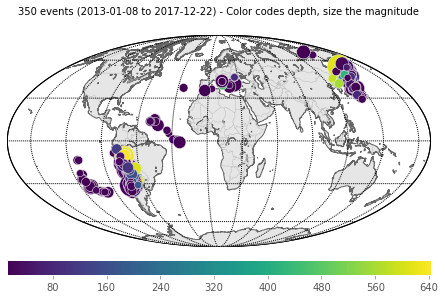

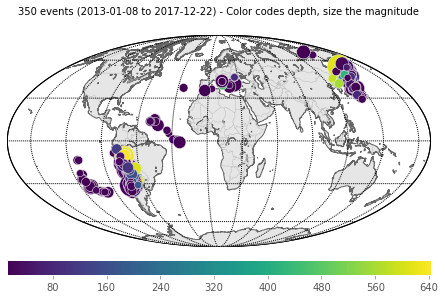

In [6]:
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.syngine import Client
from obspy.taup import TauPyModel

cat = obspy.core.event.Catalog()

for year in years:
    for month in months:
        tmp = obspy.read_events('%s%02d.ndk' % (month, year))
        cat = cat + tmp.filter('magnitude >= 5.5')
    
    
cat2 = obspy.core.event.Catalog()

for evt in cat:
    elat=evt.origins[0].latitude
    elon=evt.origins[0].longitude
    slat=sta.latitude
    slon=sta.longitude
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg=delm/1000/111.11
    if deldeg > 55 and deldeg < 85:
        cat2.append(evt)
        
cat2.plot()
    

In [ ]:
from scipy.signal import tukey
from numpy import arange, linspace, zeros
from numpy.random import randn
from numpy import argmax, nan
import warnings
warnings.filterwarnings('ignore')

model = TauPyModel(model="iasp91")

#tries = linspace(0.5, 0.90, 5)
pctage=0.80

#tshifts = [-6, -3, 0, 3, 6]
tshifts = [0]

rbin    = zeros(len(tshifts)*len(cat2)*700).reshape(len(tshifts),len(cat2),700) * nan
rbin_s  = rbin.copy()
mbin1   = zeros(len(tshifts)*len(cat2)).reshape(len(tshifts),len(cat2)) * nan
mbin1_s = mbin1.copy()
mbin2   = mbin1.copy()
mbin2_s = mbin1.copy()

for ievt in range(len(cat2)):
    print('Working on %5d of %5d' % (ievt+1,len(cat2)))

    strike=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.strike
    dip=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.dip
    rake=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.rake

    quake_depth_in_km=cat2[ievt].preferred_origin().depth/1000.0
    
    etime = cat2[ievt].preferred_origin().time

    slat=sta.latitude
    slon=sta.longitude
    elat=cat2[ievt].preferred_origin().latitude
    elon=cat2[ievt].preferred_origin().longitude

    client_syn = Client()
    
    t1=etime
    t2=etime+3600./2.

    for wvfrm_type in ['data','synthetic']:
    
        if wvfrm_type == 'synthetic':
            tmpstr = '%8.1f %8.1f %6.1f %8.1f %8.1f %8.2f %8.2f %8.2f ' % (elat, elon, quake_depth_in_km, slat, slon, strike, dip, rake)
            print(tmpstr)
            stis = client_syn.get_waveforms(model="iasp91_2s",
                                              sourcelatitude=elat,
                                              sourcelongitude=elon,
                                              sourcedepthinmeters=1000.*quake_depth_in_km,
                                              receiverlatitude=slat, receiverlongitude=slon,
                                              sourcedoublecouple=[strike,dip,rake],
                                              origintime=etime,
                                              units='velocity', starttime=t1, endtime=t2)
        else:
            #
            try:
                stis=client.get_waveforms(network,station,'10','LH?',t1,t2,attach_response=True)
            except:
                print('  get_waveforms failed.')
                break

            pre_filt = (0.005, 0.01, 5.0, 10.0)
            stis.remove_response(output='VEL', pre_filt=pre_filt)
            #


        print(stis)

        #print('...strike, dip, rake, elat, elon, quake_depth_in_km = %3d %3d %3d %5d %5d %5d %5d' % (strike, dip, rake, elat, elon, slat, quake_depth_in_km))


        delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
        deldeg=delm/1000/111.11

        arrivals = model.get_travel_times(source_depth_in_km=quake_depth_in_km, distance_in_degree=deldeg,phase_list=['S'])

        stis.rotate('->ZNE',inventory=inv)
        #stis.rotate('NE->RT', back_azimuth = baz)
        stis.rotate('ZNE->LQT', inclination=arrivals[0].incident_angle, back_azimuth = baz)
        stis.detrend()

        stis.filter('bandpass', freqmin = 1./100., freqmax = 1./8., zerophase=True)
        #stis.filter('highpass', freq=1./20., zerophase=True)
        stis.resample(5)
        stis.differentiate()

        t1=etime+arrivals[0].time - 50
        t2=etime+arrivals[0].time + 50

        for ii, tshift in enumerate(tshifts):

            stis2=stis.copy().trim(t1+tshift,t2+tshift)

            dt = stis2[0].stats.delta

            assert 'L' in stis2[0].stats.channel
            assert 'Q' in stis2[1].stats.channel
            assert 'T' in stis2[2].stats.channel
            
            

            P = stis2[1].copy().data
            D = stis2[0].copy().data

            #Indeces to mask out
            i1 = int(len(P) * (pctage)/2)
            i2 = int(len(P) - i1)
            
            N1=P.copy()[:i1]
            N2=D.copy()[:i1]

            P[:i1]=0.0
            P[i2:]=0.0
            P[i1:i2]= P[i1:i2] * tukey(len(P[i1:i2]))

            smax  = max(abs(P))
            nmax1 = max(abs(N1))
            nmax2 = max(abs(N2))
            #print(i1,i2,imax)
            
            TB = 1.5
            NT = 2

            Poverlap = 0.99
            win_len  = 100

            #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=0.99, win_len=70)
            times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)
            _, RFnorm = ETMTM(P,P,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

            if wvfrm_type == 'synthetic':
                rbin_s[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1_s[ii,ievt] = smax/nmax1
                mbin2_s[ii,ievt] = smax/nmax2
            else:
                rbin[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1[ii,ievt] = smax/nmax1
                mbin2[ii,ievt] = smax/nmax2
        
from numpy import save
save('array_dump',rbin)
save('max_dump',mbin)

In [ ]:
from numpy import save
save('array_dump',rbin)
save('max_dump',mbin)
save('array_dump_s',rbin_s)
save('max_dump_s',mbin_s)
!ls -lth *.npy

In [ ]:
from numpy import isnan
#mbin1_s[0,:]
#plt.hist(mbin[4,:],range=(0.1,1.0),alpha=0.5)
plt.scatter(mbin1_s[~isnan(mbin1_s)],mbin2_s[~isnan(mbin2_s)],alpha=0.5)
#plt.show()

In [ ]:
from numpy import nanmean, nanmedian, nanstd
from numpy.random import choice

#times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

#nrfs = len(cat2)
#nrfs = 329

minsnrs = arange(0, 20, 5)

#rbin_sn = rbin_s.copy() + randn(rbin_s.shape[0],rbin_s.shape[1],rbin_s.shape[2])*0.05

for iplt, minsnr in enumerate(minsnrs):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        snr_sample = arange(len(cat2))[mbin2[0,:]>minsnr]
        
        nrfs = len(snr_sample)
        
        rbin1=rbin0[0,snr_sample,:]
        
        nboot = 500

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        for iboot in range(nboot):
            random_sample = choice(range(nrfs), nrfs, replace=True)
            bbin[iboot,:] = nanmedian(rbin1[random_sample,:len(RF)],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(minsnrs),iplt+1)
        else:
            plt.subplot(2,len(minsnrs),iplt+1+len(minsnrs))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        if irow == 0:
            plt.title('SNR Cutoff = %2d' % (minsnr) )

plt.subplot(2,len(minsnrs),1)
plt.ylabel('Data\nTime (s)')
plt.subplot(2,len(minsnrs),1+len(minsnrs))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')

#plt.ylabel('Time (s)')
#plt.xlabel('RF Amplitude')
    
plt.tight_layout()
plt.savefig('RSSD_SNR.eps')

In [ ]:
times = arange(len(P))*stis[0].stats.delta
plt.plot(times,P)
stis.plot()

In [ ]:
from numpy import nanmean, nanmedian, nanstd, array, shape
from numpy.random import choice

times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

tmp=[]
for ievt, evt in enumerate(cat2):
    elat=evt.preferred_origin().latitude
    elon=evt.preferred_origin().longitude
    edep=evt.preferred_origin().depth/1000.0
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg = delm/1000./111.11
    tmp.append(baz)
    
plt.hist(tmp)

depthranges = [(30,135),(135,165),(300,350)]

iplt = 4

for iplt, depthrange in enumerate(depthranges):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        dmin, dmax = depthrange[0], depthrange[1]

        slic = array(array(tmp) > dmin) & array(array(tmp) < dmax)

        #print(dmin, dmax, len(slic))

        nboot = 100

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        rbin2 = rbin0[0,slic,:len(RF)]
        nrf,_ = shape(rbin2)

        for iboot in range(nboot):

            random_sample = choice(range(nrf), nrf, replace=True)

            #print(nrf, len(random_sample))

            bbin[iboot,:] = nanmedian(rbin2[random_sample,:],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(depthranges),iplt+1)
        else:
            plt.subplot(2,len(depthranges),iplt+1+len(depthranges))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        plt.xlim(-0.2,0.2)
        plt.title('Baz Limits: %3d - %3d' % (dmin, dmax))

plt.subplot(2,len(depthranges),1)
plt.ylabel('Data\nTime (s)')
        
plt.subplot(2,len(depthranges),1+len(depthranges))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')
    
#plt.tight_layout()
plt.savefig('RSSD_baz_limted.eps')